# Algothon 2024: Exploratory Data Analysis
---------

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller



## Understanding the data

In [33]:

# Load the data using pandas
data_path = 'prices.txt'

# creates data frame from text file
# a dataframe (df) is like a table, that is an object is python 
# that we can get info from
prices_df = pd.read_csv(data_path, delim_whitespace=True, header=None)

# get dimensions (aka row and column sizes) of our dataframe
df_shape = prices_df.shape

# Display the first and last few rows of the 
# DataFrame to understand its structure
df_head = prices_df.head()

df_shape, df_head


((500, 50),
       0      1      2      3      4      5      6      7      8      9   ...  \
 0  13.46  71.65  48.46  50.52  52.10  13.00  18.98  47.71  69.49  49.96  ...   
 1  13.48  72.10  48.52  50.50  52.06  12.95  18.95  47.84  69.73  49.93  ...   
 2  13.47  72.35  48.48  50.62  51.80  12.79  18.98  47.98  69.60  49.33  ...   
 3  13.53  72.51  48.42  50.75  51.66  12.66  18.96  48.74  69.54  49.67  ...   
 4  13.64  71.99  48.40  50.65  51.97  12.62  18.89  48.88  69.68  49.46  ...   
 
       40     41     42     43     44     45     46     47     48     49  
 0  32.64  55.76  14.46  58.94  36.71  52.62  49.33  36.22  49.00  56.09  
 1  32.52  55.97  14.44  59.81  36.64  52.58  49.20  36.27  48.84  56.08  
 2  32.48  56.34  14.50  59.04  36.89  52.49  49.48  36.39  48.56  55.90  
 3  32.59  56.32  14.40  58.73  36.94  52.40  49.42  36.41  49.00  56.14  
 4  32.64  56.32  14.36  59.01  37.03  52.44  49.79  36.42  48.14  55.90  
 
 [5 rows x 50 columns])

We can see there are 500 rows and 50 columns. 

Each column represents an instrument (stock). There are 50 instruments, so there are 50 columns. 
Each row represents the price of each instrument (stock) on a particular day. We have been given 500 days of data, so there are 500 rows. 

So prices.txt is training data. We want to build a model that reflects this data without overfitting to it. Then we will be given more data that our model can hopefully also work on. 

## Plotting the data

I will be plotting graph showing over time the changes in actual price vs my estimated price. 

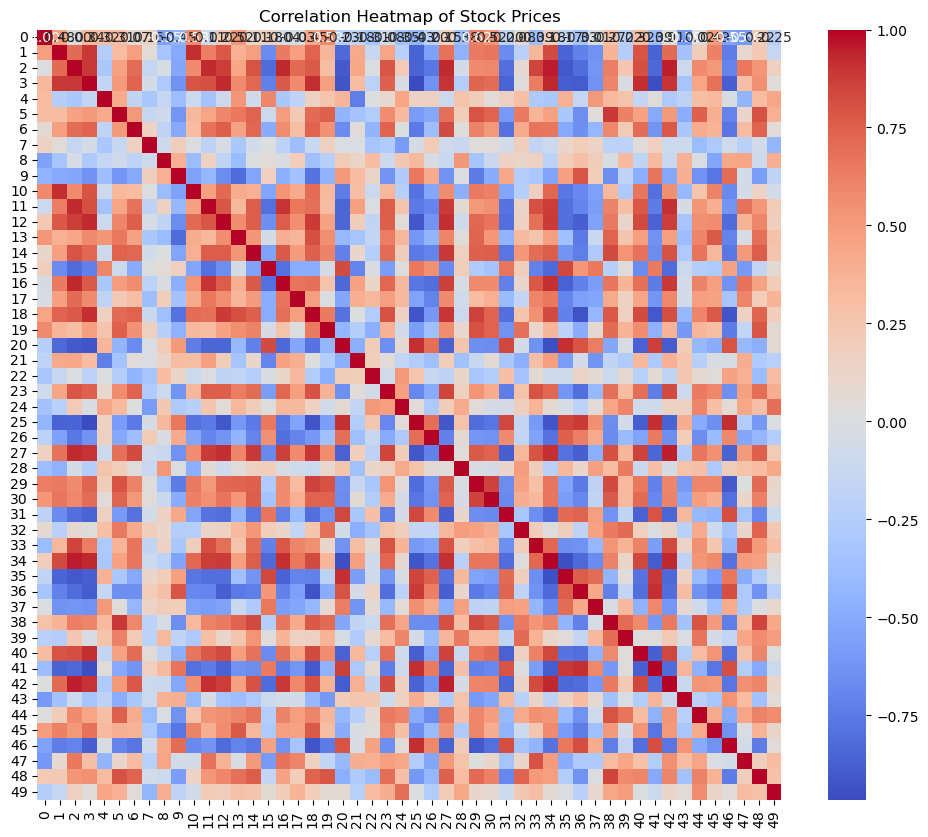

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load the data
data_path = 'prices.txt'
prices_df = pd.read_csv(data_path, delim_whitespace=True, header=None)


# Correlation Heatmap
# Calculating the correlation matrix
corr_matrix = prices_df.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Stock Prices')
plt.show()


It appears in this correlation matrix that there are clusters of stocks associated with eachother. I can tell this from the squares of similar colour. 
I should do cluster analysis to identify these as groups that move together.
Ones above a threshold 0.75 maybe. 

Apparently machine learning can be good for clustering.

###  Plotting the stock data

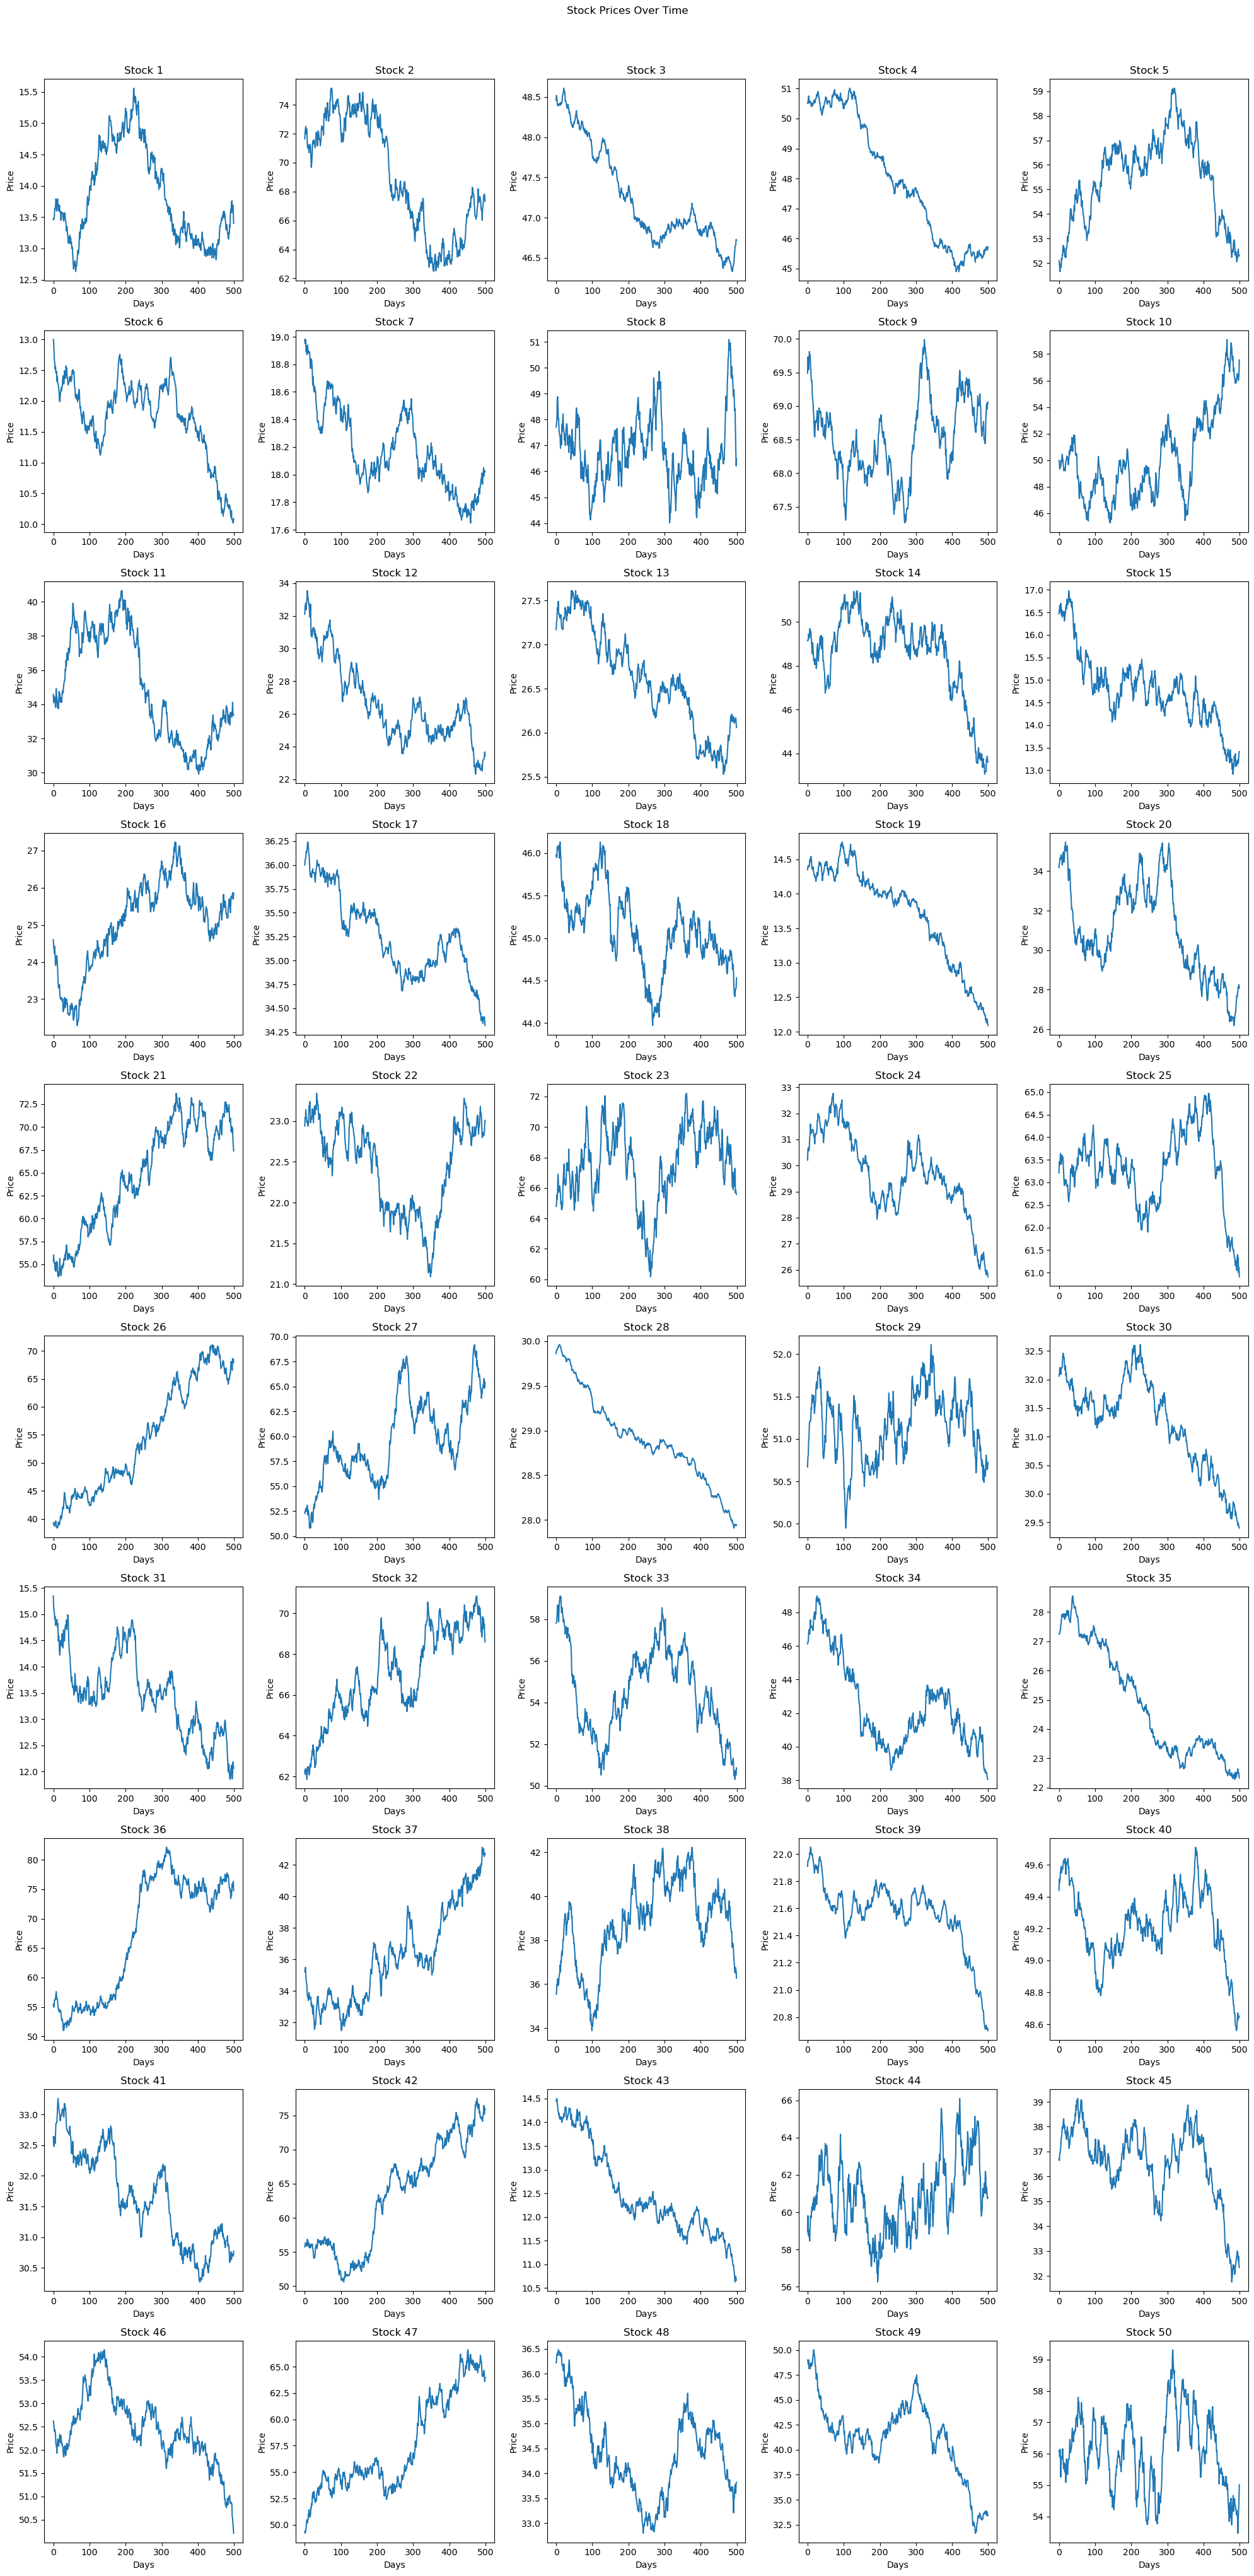

In [35]:
# Number of stocks
num_stocks = prices_df.shape[1]

# Plotting individual stock prices
plt.figure(figsize=(20, 40))
for i in range(num_stocks):
    plt.subplot(10, 5, i + 1)
    plt.plot(prices_df[i])
    plt.title(f'Stock {i + 1}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.tight_layout()

plt.suptitle('Stock Prices Over Time', y=1.02)
plt.show()

From these plots, we can see some stocks are doing mean reverting (going up and down and then returning the mean) and other stocks have a trend, like they are slowly and consistently plummeting down.

Maybe I could do analysis that showed for stocks that have a z-score close to the mean - showing it is flucuating within bounds, we can use mean regression on those stocks.
- Calculate Z-Scores: Calculate the z-scores for each stock to identify deviations from the mean.
- Statistical Tests: Perform statistical tests like the ADF test for stationarity. Tests like the Augmented Dickey-Fuller (ADF) test or the Phillips-Perron test can help determine if stock prices revert to a mean over time.

Then we can have a different approach like linear regression for the stocks that are not mean-reverting. 



# Doing ADF tests and Transforming data

In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller



# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    return result[1]  # returning the p-value

# Initialize results dictionary
transformation_results = []

# Iterate over each stock
for i in range(prices_df.shape[1]):
    stock_series = prices_df.iloc[:, i]
    
    # Original series
    pval_original = adf_test(stock_series)
    
    # First difference
    diff_series = stock_series.diff().dropna()
    pval_diff = adf_test(diff_series)
    
    # Log transformation and differencing
    log_series = np.log(stock_series[stock_series > 0])  # Log transformation requires positive values
    log_diff_series = log_series.diff().dropna()
    pval_log_diff = adf_test(log_diff_series)
    
    # Determine the best transformation
    pvals = [pval_original, pval_diff, pval_log_diff]
    transformations = ['Original', 'Differencing', 'Log Differencing']
    
    best_transformation = transformations[np.argmin(pvals)]
    best_pval = min(pvals)
    
    transformation_results.append({
        'Stock': i + 1,
        'Best Transformation': best_transformation,
        'p-value': best_pval,
        'Stationary': 'Yes' if best_pval < 0.05 else 'No'
    })

# Create a DataFrame with the results
transformation_results_df = pd.DataFrame(transformation_results)

# Print the results
print(transformation_results_df)


    Stock Best Transformation       p-value Stationary
0       1    Log Differencing  4.999163e-30        Yes
1       2        Differencing  0.000000e+00        Yes
2       3    Log Differencing  7.729901e-26        Yes
3       4        Differencing  0.000000e+00        Yes
4       5        Differencing  0.000000e+00        Yes
5       6    Log Differencing  4.129323e-26        Yes
6       7    Log Differencing  1.685844e-29        Yes
7       8        Differencing  0.000000e+00        Yes
8       9        Differencing  2.473533e-25        Yes
9      10    Log Differencing  6.176281e-26        Yes
10     11        Differencing  0.000000e+00        Yes
11     12        Differencing  0.000000e+00        Yes
12     13        Differencing  0.000000e+00        Yes
13     14        Differencing  0.000000e+00        Yes
14     15        Differencing  0.000000e+00        Yes
15     16        Differencing  0.000000e+00        Yes
16     17        Differencing  8.126209e-18        Yes
17     18 

In [48]:
import warnings
from statsmodels.tsa.arima.model import ARIMA


# Suppress specific warnings
warnings.filterwarnings("ignore")



# Function to fit ARIMA model and predict the next day's price
def fit_arima_and_predict(transformed_series, order=(1, 1, 1)):
    model = ARIMA(transformed_series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    return forecast[0]

def get_transformed_series(series, transformation_type):
    if transformation_type == 'Original':
        return series
    elif transformation_type == 'Differencing':
        return series.diff().dropna()
    elif transformation_type == 'Log Differencing':
        log_series = np.log(series[series > 0])
        return log_series.diff().dropna()
    else:
        raise ValueError("Unknown transformation type")

def getMyPosition(prcSoFar, num_instruments=None, num_days=None):
    global currentPos
    
    (nins, nt) = prcSoFar.shape
    
    # Adjust for testing with fewer instruments and days
    if num_instruments is not None and num_instruments < nins:
        prcSoFar = prcSoFar[:num_instruments, :]
        nins = num_instruments
    
    if num_days is not None and num_days < nt:
        prcSoFar = prcSoFar[:, :num_days]
        nt = num_days
    
    if nt < 2:
        return np.zeros(nins)  # Insufficient data to predict
    
    # Prepare to store predicted prices
    predictedPrices = np.zeros(nins)
    
    # Fit ARIMA and predict next day's price for each instrument
    for i in range(nins):
        stock_series = prcSoFar[i, :]
        
        # Get best transformation type from your results
        best_transformation = transformation_results_df.iloc[i]['Best Transformation']
        
        # Transform the series
        transformed_series = get_transformed_series(pd.Series(stock_series), best_transformation)
        
        # Fit ARIMA model and predict
        try:
            prediction = fit_arima_and_predict(transformed_series)
        except:
            prediction = stock_series[-1]  # If ARIMA fails, fallback to last price
        
        # Reverse the transformation if needed (e.g., if log differenced)
        if best_transformation == 'Log Differencing':
            last_price = stock_series[-1]
            predictedPrices[i] = np.exp(np.log(last_price) + prediction)
        else:
            predictedPrices[i] = prediction
    
    latest_price = prcSoFar[:, -1]
    priceChanges = predictedPrices - latest_price
    
    lNorm = np.sqrt(priceChanges.dot(priceChanges))
    priceChanges /= lNorm
    
    scaling_factor = 5000
    rpos = np.array([int(x) for x in scaling_factor * priceChanges / latest_price])
    
    currentPos = np.array([int(x) for x in currentPos + rpos])
    return currentPos

# Example usage
# Load your price data here, for testing with fewer stocks and days
prcSoFar = np.loadtxt('prices.txt')  # This should be your actual data

# Test with fewer instruments and shorter time period
num_instruments = 50  # Choose a smaller subset of instruments
num_days = 500  # Choose a shorter time period


nInst = num_instruments
currentPos = np.zeros(nInst)

positions = getMyPosition(prcSoFar, num_instruments=num_instruments, num_days=num_days)
print(positions)

[17  0 14  0  0  7 12  0  0 14  0  0  0  0  0  0  0  0  0  6  9  0  0  0
  0  0 13  0  0 17 25  0  0  0  0  0  0  0  0 27  0 32  0  0  0  0 36  0
  0 49]


when i tried applying arima to everything else, it was very slow. for now, i will revisit mean reversion and ___ with a classifier.

# Fitting models to all stocks

- fit linear regression
- add log transformation if needed?

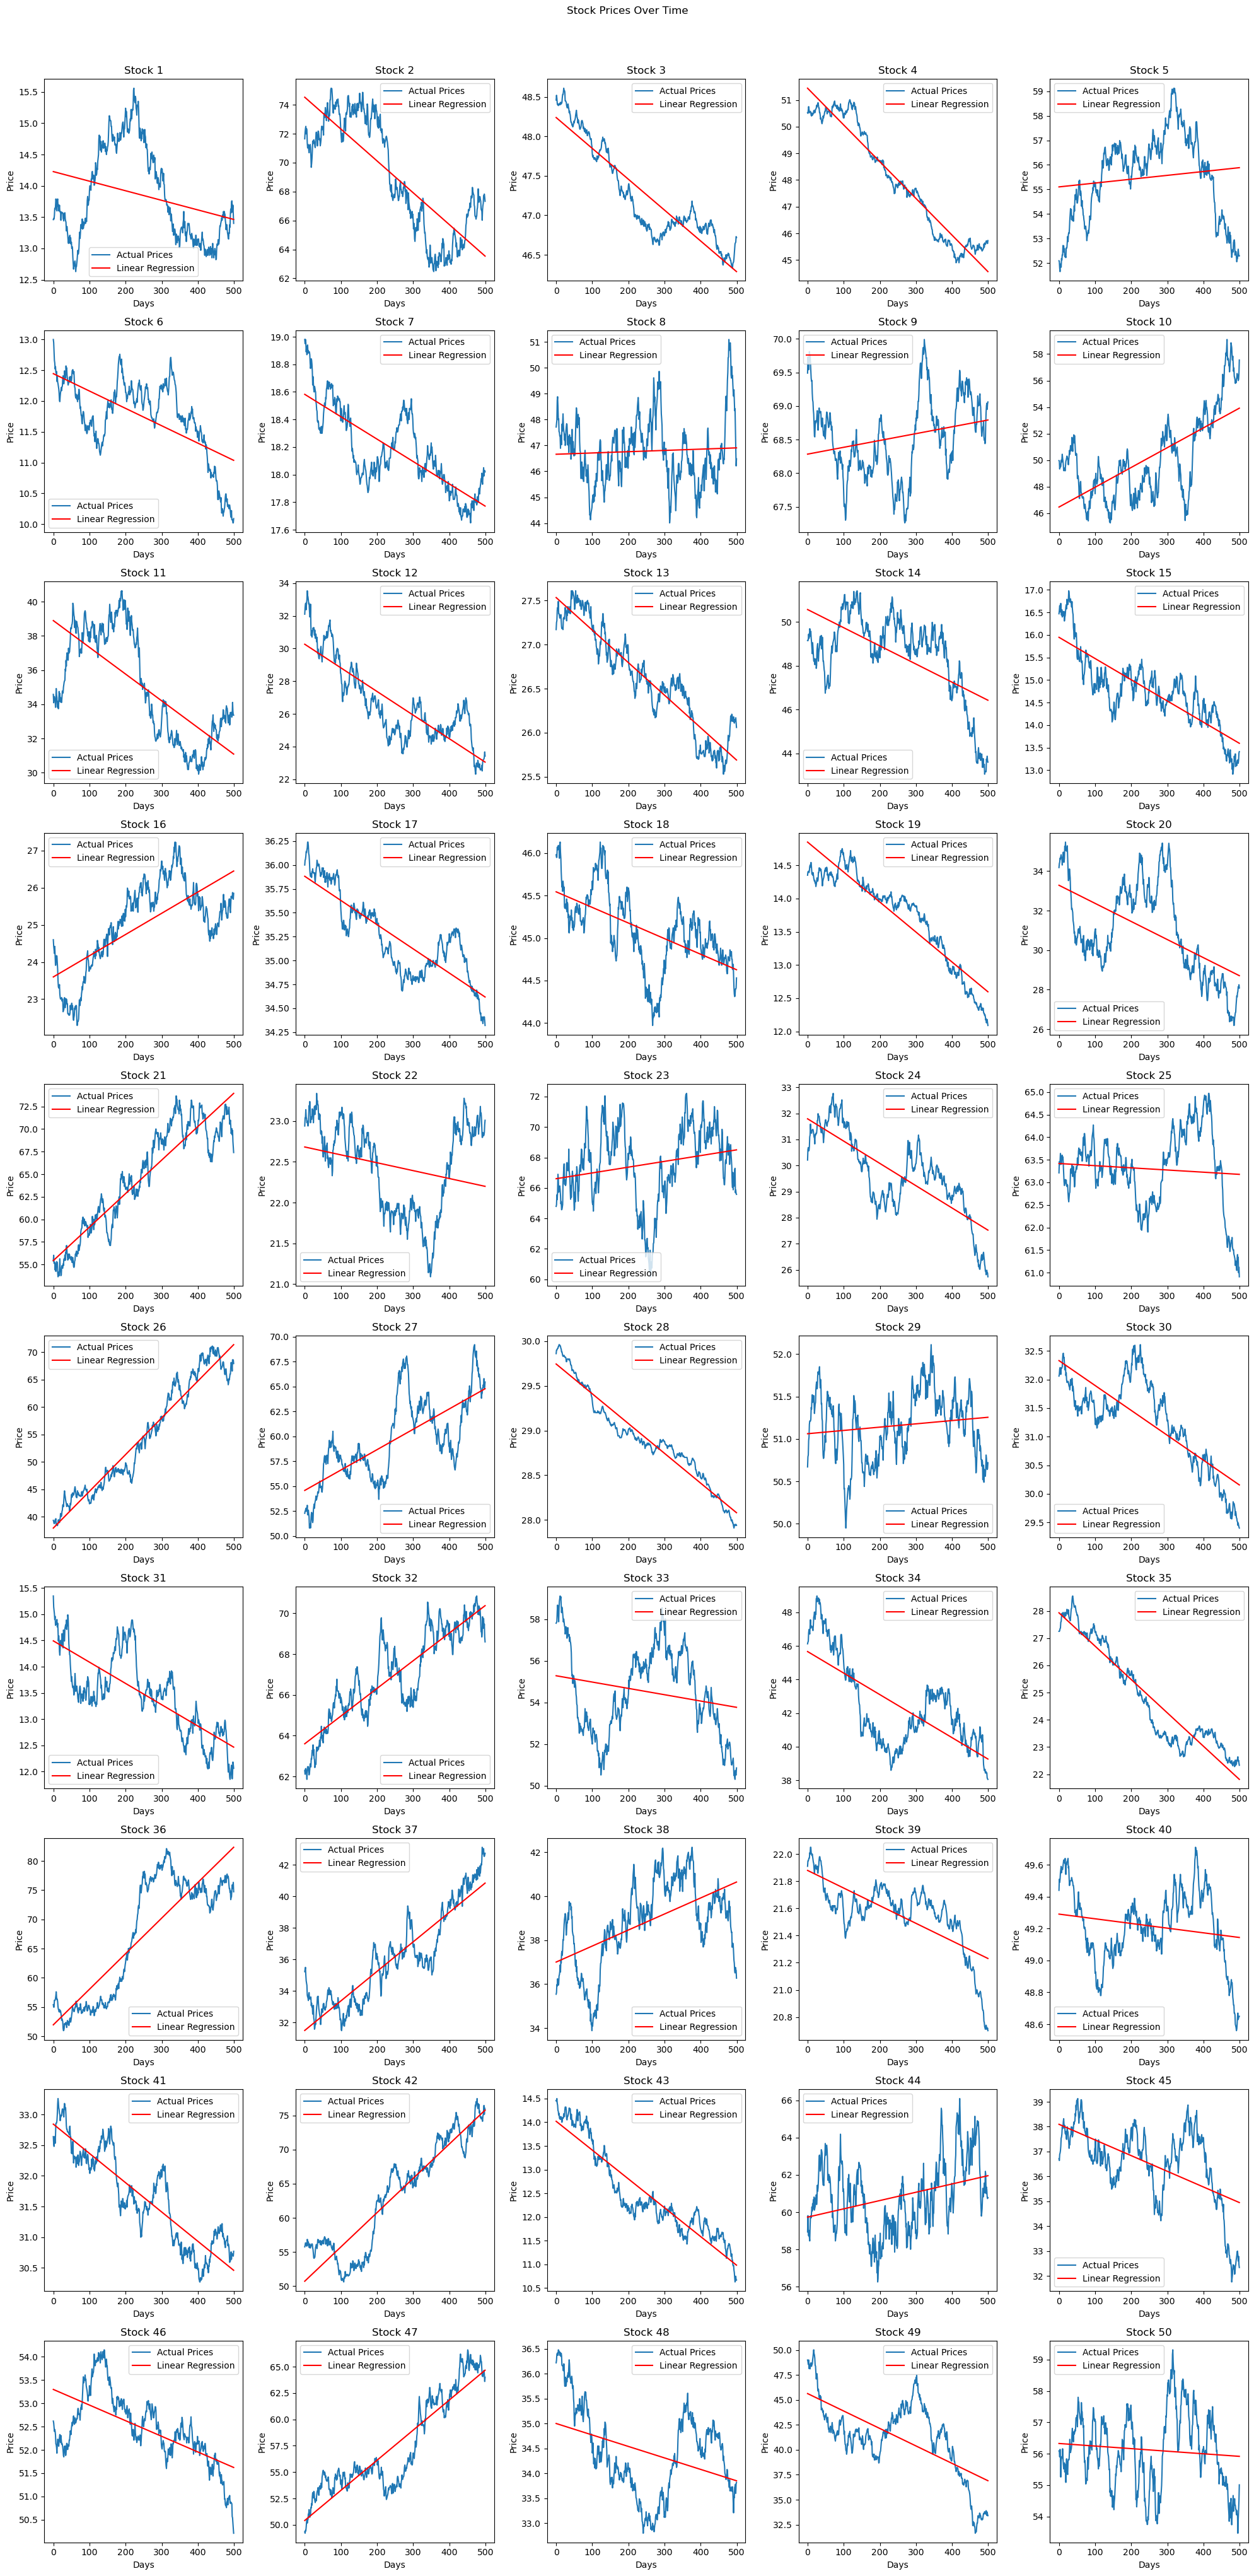

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming prices_df is your DataFrame containing the stock prices

# Number of stocks
num_stocks = prices_df.shape[1]

# Plotting individual stock prices with linear regression
plt.figure(figsize=(20, 40))
for i in range(num_stocks):
    plt.subplot(10, 5, i + 1)
    plt.plot(prices_df.iloc[:, i], label='Actual Prices')
    
    # Fit the linear regression model
    X = np.arange(len(prices_df)).reshape(-1, 1)
    y = prices_df.iloc[:, i].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the stock prices using the linear regression model
    y_pred = model.predict(X)
    
    # Plot the predicted stock prices
    plt.plot(prices_df.index, y_pred, label='Linear Regression', color='red')
    
    plt.title(f'Stock {i + 1}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Stock Prices Over Time', y=1.02)
plt.show()
